# Импорт библиотек

In [1]:
import os.path as path
import pandas as pd
import numpy as np
from tqdm import tqdm
import librosa
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchaudio
import time
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split
from transformers import AutoProcessor, ASTModel, ASTFeatureExtractor, AutoFeatureExtractor
from datasets import load_dataset

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Пути к файлам и папкам

In [2]:
home_path = "/kaggle/input/itmo-acoustic-event-detection-2023"

In [3]:
audio_train_path = path.join(home_path, "audio_train/train")
audio_test_path = path.join(home_path, "audio_test/test")
train_csv_path = path.join(home_path, "train.csv")
sample_submission_path = path.join(home_path, "sample_submission.csv")

In [4]:
files = os.listdir(audio_train_path)
filename = random.choice(files)
filename

'c5042ee2489b3e469e07.wav'

# Подготовка данных

In [5]:
label_df = pd.read_csv(train_csv_path)
sample_df = pd.read_csv(sample_submission_path)
label_df

,fname,label
0,8bcbcc394ba64fe85ed4.wav,Finger_snapping
1,00d77b917e241afa06f1.wav,Squeak
2,17bb93b73b8e79234cb3.wav,Electric_piano
3,7d5c7a40a936136da55e.wav,Harmonica
4,17e0ee7565a33d6c2326.wav,Snare_drum
...,...,...
5678,edd5f2d5bdab597ab6f1.wav,Cello
5679,cc489c6414c2c25bfa6d.wav,Shatter
5680,ac3177fbe1f9b0155920.wav,Cello
5681,9da56639ef3113293961.wav,Snare_drum


In [6]:
unique_labels = np.unique(label_df['label'])
label_value_dict = {label: index for index, label in enumerate(unique_labels)}
label_value_dict

{'Acoustic_guitar': 0,
 'Applause': 1,
 'Bark': 2,
 'Bass_drum': 3,
 'Burping_or_eructation': 4,
 'Bus': 5,
 'Cello': 6,
 'Chime': 7,
 'Clarinet': 8,
 'Computer_keyboard': 9,
 'Cough': 10,
 'Cowbell': 11,
 'Double_bass': 12,
 'Drawer_open_or_close': 13,
 'Electric_piano': 14,
 'Fart': 15,
 'Finger_snapping': 16,
 'Fireworks': 17,
 'Flute': 18,
 'Glockenspiel': 19,
 'Gong': 20,
 'Gunshot_or_gunfire': 21,
 'Harmonica': 22,
 'Hi-hat': 23,
 'Keys_jangling': 24,
 'Knock': 25,
 'Laughter': 26,
 'Meow': 27,
 'Microwave_oven': 28,
 'Oboe': 29,
 'Saxophone': 30,
 'Scissors': 31,
 'Shatter': 32,
 'Snare_drum': 33,
 'Squeak': 34,
 'Tambourine': 35,
 'Tearing': 36,
 'Telephone': 37,
 'Trumpet': 38,
 'Violin_or_fiddle': 39,
 'Writing': 40}

# Подготовка и тестирование оборудования

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
cpu_count = os.cpu_count()
num_workers = cpu_count if device == "cpu" else 0
num_workers, cpu_count

(0, 2)

In [9]:
def set_random_state(random_state):
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [10]:
RANDOM_STATE = 42

In [11]:
torch.use_deterministic_algorithms(True)

In [12]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=42


# Датасет

In [13]:
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

In [14]:
def extract_feature(audio_path, fname, sr):
    x = librosa.load(path.join(audio_path, fname), sr=sr)[0]
    x, _ = librosa.effects.trim(x)
    x = feature_extractor(x, sampling_rate=sr, return_tensors="pt")["input_values"]
    return x

In [15]:
start_time = time.time()

X = [extract_feature(audio_train_path, fname, 16000) for fname in label_df["fname"]]

X_test = [extract_feature(audio_test_path, fname, 16000) for fname in sample_df["fname"]]

print(time.time() - start_time, "seconds")

312.029194355011 seconds


In [16]:
class EventDetectionDataset(Dataset):
    def __init__(self, X, y=None, device="cpu"):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.y is not None:
            return \
                x,\
                self.y[idx]
        return x

In [17]:
y = [label_value_dict[label] for label in label_df["label"]]

In [18]:
dataset = EventDetectionDataset(X, y)

In [19]:
trainset, valset = random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

In [20]:
testset = EventDetectionDataset(X_test)

In [21]:
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(valset, batch_size=8, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=num_workers)

# Архитектура нейронной сети

In [22]:
pretrained_model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

Some weights of the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 were not used when initializing ASTModel: ['classifier.layernorm.bias', 'classifier.layernorm.weight', 'classifier.dense.weight', 'classifier.dense.bias']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
class MyNetwork(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(MyNetwork, self).__init__()
        self.pretrained_model = pretrained_model
        
        self.bn = nn.BatchNorm1d(num_features=768)
        self.dropout = nn.Dropout(p=0.3)
                
        self.fc = nn.Linear(768, num_classes)
        
    def forward(self, x):
        x = x.squeeze(1)
        x = self.pretrained_model(input_values=x).last_hidden_state
        x, _ = x.max(dim=1)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

# Обучение и проверка точности на наборе данных

In [24]:
def evaluate(network, val_loader, device=device):
    loss_list = []
    outputs = []
    targets = []
    network.eval()
    with torch.no_grad():
        for i_batch, sample_batched in tqdm(enumerate(val_loader)):
            x, y = sample_batched
            x, y = x.to(device), y.to(device)
            
            output = network(x)
            outputs.append(output.argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())

        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)

        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        
        print(f'[Val] accuracy:  {acc:.5f}; mean loss:  {val_loss[-1]:.5f}', end="\n\n")

In [25]:
def train(network, train_loader, optimizer, criterion, device=device):
    loss_list = []
    outputs = []
    targets = []
    network.train()
    for i_batch, sample_batched in tqdm(enumerate(train_loader)):
        x, y = sample_batched
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.argmax(axis=1))

        target = y
        targets.append(target)

        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    
    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)

    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    
    print(f'[Train] accuracy:  {acc:.5f}; mean loss:  {train_loss[-1]:.5f}', end="\n\n")

In [26]:
n_epoch = 10

set_random_state(RANDOM_STATE)

criterion = nn.CrossEntropyLoss()
network = MyNetwork(pretrained_model, 41).to(device)

optimizer = optim.AdamW(network.parameters(), lr=0.000005, weight_decay=0.00001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print(f'epoch #{e+1}')
    train(network, train_loader, optimizer, criterion, device=device)
    evaluate(network, val_loader, device=device)

epoch #1


640it [13:00,  1.22s/it]


[Train] accuracy:  0.46354; mean loss:  2.37895



71it [00:30,  2.33it/s]


[Val] accuracy:  0.75704; mean loss:  1.17903

epoch #2


640it [12:55,  1.21s/it]


[Train] accuracy:  0.79863; mean loss:  1.03170



71it [00:30,  2.33it/s]


[Val] accuracy:  0.83803; mean loss:  0.76722

epoch #3


640it [12:56,  1.21s/it]


[Train] accuracy:  0.88465; mean loss:  0.61751



71it [00:30,  2.34it/s]


[Val] accuracy:  0.85211; mean loss:  0.62228

epoch #4


640it [12:56,  1.21s/it]


[Train] accuracy:  0.92649; mean loss:  0.41871



71it [00:30,  2.33it/s]


[Val] accuracy:  0.86620; mean loss:  0.54912

epoch #5


640it [12:56,  1.21s/it]


[Train] accuracy:  0.95758; mean loss:  0.27415



71it [00:30,  2.33it/s]


[Val] accuracy:  0.87324; mean loss:  0.50939

epoch #6


640it [12:56,  1.21s/it]


[Train] accuracy:  0.97791; mean loss:  0.18495



71it [00:30,  2.33it/s]


[Val] accuracy:  0.87852; mean loss:  0.47767

epoch #7


640it [12:56,  1.21s/it]


[Train] accuracy:  0.99159; mean loss:  0.12244



71it [00:30,  2.33it/s]


[Val] accuracy:  0.88028; mean loss:  0.45534

epoch #8


640it [12:56,  1.21s/it]


[Train] accuracy:  0.99609; mean loss:  0.08367



71it [00:30,  2.33it/s]


[Val] accuracy:  0.89437; mean loss:  0.44178

epoch #9


640it [12:56,  1.21s/it]


[Train] accuracy:  0.99804; mean loss:  0.05797



71it [00:30,  2.33it/s]


[Val] accuracy:  0.89613; mean loss:  0.43739

epoch #10


640it [12:56,  1.21s/it]


[Train] accuracy:  0.99902; mean loss:  0.04358



71it [00:30,  2.33it/s]

[Val] accuracy:  0.88556; mean loss:  0.43456



# Визуализация процесса обучения сети

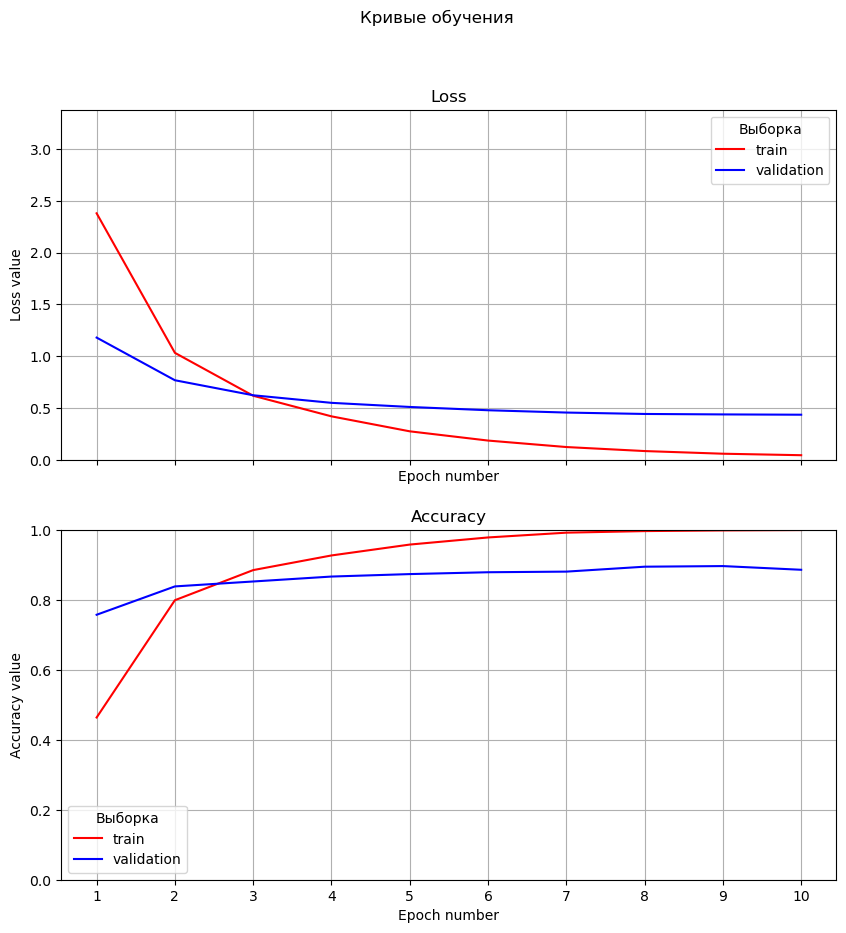

In [27]:
epochs = range(1, n_epoch+1)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

xticks = range(1, n_epoch+1, n_epoch // 10) if n_epoch > 10 else epochs

# draw loss
ax_top.plot(epochs, train_loss, 'r', label='train')
ax_top.plot(epochs, val_loss, 'b', label='validation')

ax_top.set(
    title='Loss',
    xlabel='Epoch number',
    ylabel='Loss value',
    ylim=[0, max(max(train_loss), max(val_loss)) + 1],
)
ax_top.legend(
    title="Выборка",
)
ax_top.grid()

# draw accuracy
ax_bottom.plot(epochs, train_acc, 'r', label='train')
ax_bottom.plot(epochs, val_acc, 'b', label='validation')

ax_bottom.set(
    title='Accuracy',
    xlabel='Epoch number',
    ylabel='Accuracy value',
    xticks=xticks,
    ylim=[0, 1],
)
ax_bottom.legend(
    title="Выборка",
)
ax_bottom.grid()

fig.suptitle("Кривые обучения")

plt.show()

# Предсказание результатов

In [28]:
test_outputs = []
with torch.no_grad():
    for i_batch, sample_batched in enumerate(test_loader):
        x = sample_batched
        x = x.to(device)
        output = network(x)
        test_outputs.append(output.argmax(axis=1))
    y_pred = torch.hstack(test_outputs).numpy(force=True)

In [29]:
submission_data = pd.DataFrame({'fname': sample_df["fname"], 'index_label': y_pred})
submission_data

,fname,index_label
0,973a8b381d1875ebe120.wav,25
1,052e1cbeb4391d6af234.wav,0
2,16eb98d96319450e0949.wav,25
3,ff13c136c04f274229a5.wav,25
4,b458211304f7a14b29b2.wav,10
...,...,...
3785,959206e695c2ceed3d3b.wav,3
3786,3624e1c6d306945d7ba9.wav,3
3787,4a22b7dd3f519e2a9111.wav,36
3788,a2c95e48acc6a3ec2696.wav,12


In [30]:
submission_data['label'] = submission_data['index_label'].apply(lambda index: next(label for label, id in label_value_dict.items() if id == index))
submission_data

,fname,index_label,label
0,973a8b381d1875ebe120.wav,25,Knock
1,052e1cbeb4391d6af234.wav,0,Acoustic_guitar
2,16eb98d96319450e0949.wav,25,Knock
3,ff13c136c04f274229a5.wav,25,Knock
4,b458211304f7a14b29b2.wav,10,Cough
...,...,...,...
3785,959206e695c2ceed3d3b.wav,3,Bass_drum
3786,3624e1c6d306945d7ba9.wav,3,Bass_drum
3787,4a22b7dd3f519e2a9111.wav,36,Tearing
3788,a2c95e48acc6a3ec2696.wav,12,Double_bass


In [31]:
submission_data = submission_data[['fname', 'label']]

In [32]:
submission_data

,fname,label
0,973a8b381d1875ebe120.wav,Knock
1,052e1cbeb4391d6af234.wav,Acoustic_guitar
2,16eb98d96319450e0949.wav,Knock
3,ff13c136c04f274229a5.wav,Knock
4,b458211304f7a14b29b2.wav,Cough
...,...,...
3785,959206e695c2ceed3d3b.wav,Bass_drum
3786,3624e1c6d306945d7ba9.wav,Bass_drum
3787,4a22b7dd3f519e2a9111.wav,Tearing
3788,a2c95e48acc6a3ec2696.wav,Double_bass


In [33]:
submission_data.to_csv('submission.csv', index=False)